# Common Libraries

In [1]:
import os
import sys
import numpy as np
import nibabel as nb
from pathlib import Path
import matplotlib.pylab as plt
from scipy.stats import ttest_1samp
from matplotlib.lines import Line2D

# Custom Libraries

In [2]:
from easysurfvis.cores.surface_data import surf_paths, sample_dir_path
from easysurfvis.cores.surface_util import get_bounding_box
from easysurfvis.cores.surface_roi import detect_sulcus, detect_roi_names

from easysurfvis.profile_analysis import surface_profile, draw_both_hemi_cross_section_1dPlot, sulcus_abbreviation_name, draw_profile_datas, draw_both_hemi_profile
from easysurfvis.surface_visualization import show_both_hemi_sampling_coverage, show_both_hemi_stats, plot_virtualStrip_on3D_surf

# Params

In [3]:
surf_resolution = 32

# Sample datas
l_sample_data1_path = os.path.join(sample_dir_path, "l_sampling_datas1.npy")
r_sample_data1_path = os.path.join(sample_dir_path, "r_sampling_datas1.npy")

l_sample_data2_path = os.path.join(sample_dir_path, "l_sampling_datas2.npy")
r_sample_data2_path = os.path.join(sample_dir_path, "r_sampling_datas2.npy")

# ROI
atlas = "Brodmann"

# For cross-section analysis (virtual strip)
L_from_point = np.array([-24, 111])  
L_to_point = np.array([81, 47])    

R_from_point = np.array([23, 80])
R_to_point = np.array([-75, 22]) 

width = 20
cross_section_n_sampling = 30

# Paths
save_dir_path = "/mnt/ext1/seojin/temp"

# Load datas

In [4]:
# Sample datas
l_sample_datas1 = np.load(l_sample_data1_path)
r_sample_datas1 = np.load(r_sample_data1_path)

l_sample_datas2 = np.load(l_sample_data2_path)
r_sample_datas2 = np.load(r_sample_data2_path)

l_surf_info = surf_paths("L", atlas = atlas)
r_surf_info = surf_paths("R", atlas = atlas)

# Cross section analysis

In [5]:
# Data1
l_cross_section_data1 = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                        surface_data = l_sample_datas1,
                                        from_point = L_from_point,
                                        to_point = L_to_point,
                                        width = width,
                                        n_sampling = cross_section_n_sampling)

r_cross_section_data1 = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                        surface_data = r_sample_datas1,
                                        from_point = R_from_point,
                                        to_point = R_to_point,
                                        width = width,
                                        n_sampling = cross_section_n_sampling)

# Data2
l_cross_section_data2 = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                        surface_data = l_sample_datas2,
                                        from_point = L_from_point,
                                        to_point = L_to_point,
                                        width = width,
                                        n_sampling = cross_section_n_sampling)

r_cross_section_data2 = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                        surface_data = r_sample_datas2,
                                        from_point = R_from_point,
                                        to_point = R_to_point,
                                        width = width,
                                        n_sampling = cross_section_n_sampling)

# Cross-section analysis coverages

save: /mnt/ext1/seojin/temp/L_hemi_coverage.png
save: /mnt/ext1/seojin/temp/R_hemi_coverage.png
save: /mnt/ext1/seojin/temp/both_hemi_coverage.png


<Figure size 640x480 with 0 Axes>

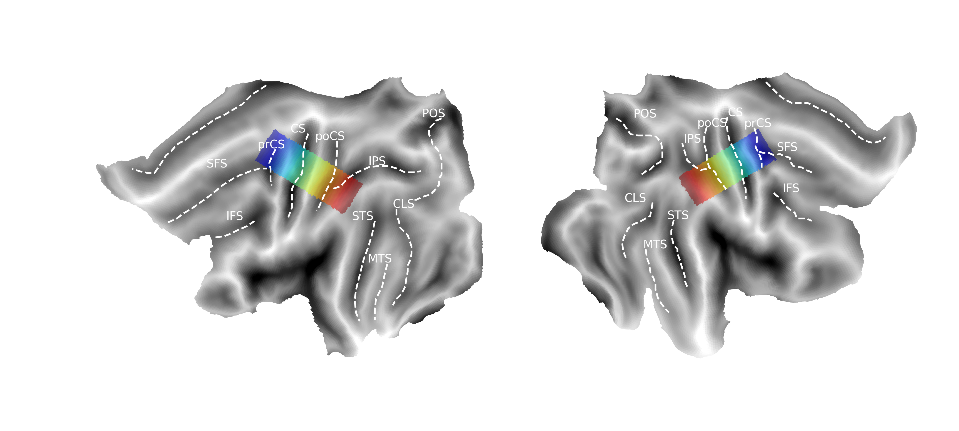

In [6]:
show_both_hemi_sampling_coverage(l_sampling_coverage = l_cross_section_data1["sampling_coverages"],
                                 r_sampling_coverage = r_cross_section_data1["sampling_coverages"],
                                 save_dir_path = save_dir_path,
                                 surf_resolution = surf_resolution,
                                 is_sulcus_label = True)

# Surf ROI

In [7]:
# Virtual strip
l_virtual_stip_mask = l_cross_section_data1["virtual_stip_mask"]
r_virtual_stip_mask = r_cross_section_data1["virtual_stip_mask"]
left_bounding_box = get_bounding_box("L", l_virtual_stip_mask)
right_bounding_box = get_bounding_box("R", r_virtual_stip_mask)

save: /mnt/ext1/seojin/temp/L_virtual_strip.png


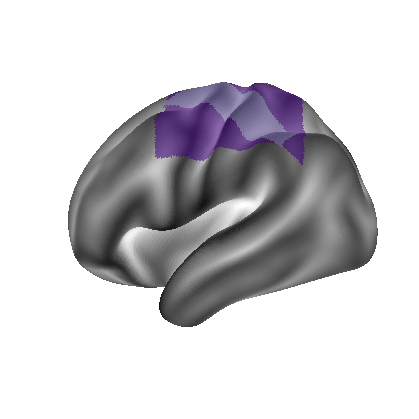

In [8]:
l_strip_fig = plot_virtualStrip_on3D_surf(l_virtual_stip_mask, 
                                          hemisphere = "L",
                                          save_dir_path = save_dir_path,
                                          view = (0, 180),
                                          vmax = 1,
                                          darkness = 1)

save: /mnt/ext1/seojin/temp/R_virtual_strip.png


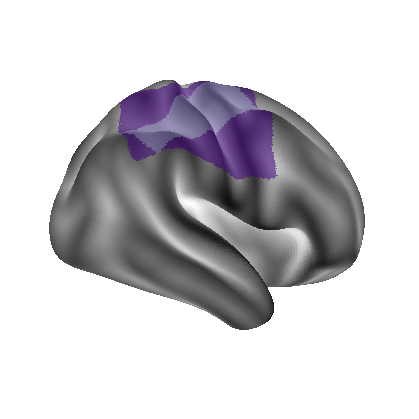

In [9]:
r_strip_fig = plot_virtualStrip_on3D_surf(r_virtual_stip_mask, 
                                          hemisphere = "R",
                                          save_dir_path = save_dir_path,
                                          view = (0, 0),
                                          vmax = 1,
                                          darkness = 1)

# Focused area

In [ ]:
l_surf_mean = np.mean(l_sample_datas1, axis = 1)
r_surf_mean = np.mean(r_sample_datas1, axis = 1)
fig, axis = show_both_hemi_stats(l_stat = l_surf_mean,
                                 r_stat = r_surf_mean,
                                 threshold = 0.0001,
                                 cscale = (0.0001, 0.001),
                                 save_dir_path = save_dir_path,
                                 left_bounding_box = left_bounding_box,
                                 right_bounding_box = right_bounding_box,
                                 is_focusing_bounding_box = True)

save: /mnt/ext1/seojin/temp/L_hemi_stat.png
save: /mnt/ext1/seojin/temp/R_hemi_stat.png
save: /mnt/ext1/seojin/temp/colorbar.png


# 1D-plot for sampling areas

## Detect sulcus & roi names

In [ ]:
def get_rois(sampling_coverages, hemisphere):
    rois = detect_roi_names(sampling_coverages, hemisphere)
    rois = [roi.replace("|", "") for roi in rois]
    rois = np.array([roi.replace(f"{hemisphere}_", "") for roi in rois])
    rois[np.where(rois == "2")[0]] = "1+2+3"
    rois = np.where(rois == "1+2+3", "3+1+2", rois)
    rois = np.array([roi.replace("+", ", ") for roi in rois])

    return rois

In [ ]:
# Suclus names
l_sulcus_names = detect_sulcus("L", l_cross_section_data1["sampling_coverages"], False)
r_sulcus_names = detect_sulcus("R", r_cross_section_data1["sampling_coverages"], False)[::-1]
r_sulcus_names[-1] = ""

# region names
l_roi_names = get_rois(l_cross_section_data1["sampling_coverages"], hemisphere = "L")
r_roi_names = get_rois(r_cross_section_data1["sampling_coverages"], hemisphere = "R")[::-1]

## Stats

In [ ]:
l_sampling_datas = np.concatenate([np.expand_dims(l_cross_section_data1["sampling_datas"], axis = 0), 
                                   np.expand_dims(l_cross_section_data2["sampling_datas"], axis = 0)], axis = 0)

r_sampling_datas = np.concatenate([np.expand_dims(r_cross_section_data1["sampling_datas"][::-1], axis = 0), 
                                   np.expand_dims(r_cross_section_data2["sampling_datas"][::-1], axis = 0)], axis = 0)

# Plotting

In [ ]:
fig, axis = draw_both_hemi_cross_section_1dPlot(y_range = (0, 0.0014), 
                                                l_sampling_datas = l_sampling_datas,
                                                l_sulcus_names = l_sulcus_names,
                                                l_roi_names = l_roi_names,
                                                r_sampling_datas = r_sampling_datas,
                                                r_sulcus_names = r_sulcus_names,
                                                r_roi_names = r_roi_names,
                                                cmap = "tab10")

cmap = plt.get_cmap("tab10", 10)
custom_lines = [Line2D([0], [0], color = cmap.colors[0], lw = 2, label = "Move")]
    
# Add the legend to the figure
fig.legend(handles = custom_lines, 
           loc = "upper right", 
           ncol = 1, 
           bbox_to_anchor=(1.06, 1),
           fontsize = 14)

fig.tight_layout()
file_path = os.path.join(save_dir_path, "both_hemi_1dplot.png")
fig.savefig(file_path, transparent = True, bbox_inches = "tight")
print(f"save: {file_path}")

In [ ]:
fig, axes = draw_both_hemi_profile(l_sampling_datas = l_sampling_datas,
                                   l_sulcus_names = l_sulcus_names,
                                   l_roi_names = l_roi_names,
                                   l_p_values = ttest_1samp(l_sampling_datas, popmean = 0, axis = 2).pvalue,
                                   r_sampling_datas = r_sampling_datas,
                                   r_sulcus_names = r_sulcus_names,
                                   r_roi_names = r_roi_names,
                                   r_p_values = ttest_1samp(r_sampling_datas, popmean = 0, axis = 2).pvalue,
                                   n_inner_yTick = 1,
                                   y_ticks = np.array([-0.003, 0, 0.006]))

xmin, xmax = axes[0].get_xlim()
axes[0].hlines(y=0., xmin=xmin, xmax=xmax, color='k', linestyle='--', alpha = 0.8)

xmin, xmax = axes[1].get_xlim()
axes[1].hlines(y=0., xmin=xmin, xmax=xmax, color='k', linestyle='--', alpha = 0.8)